# Which climatology is the best for Panan-IS?

The climatology that is currently used to initialize our MOM6 and MOM5 simulations (WOA-based)is not appropriate for an Ice sheet coupled model. It is quite warm near the Ice shelves. Let's look at the different observational products for the Ice Shelf to see if we find one that makes a little more sense than the other. Let's also test an alternative extrapolation technique.


In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers = 48, memory_limit = '1350gb')

2025-05-15 09:43:00,248 - distributed.nanny - WARNING - Restarting worker


Importing data

In [3]:
lat_slice = slice(-90,-50)
Pauthenet_file = '/g/data/ik11/observations/Southern_Ocean_Climatology_PauthenetETAL2021/TS_Climato_Antarctic60S.nc'
WOA_file = '/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc'
Kaihes_file = '/g/data/ik11/users/wf4500/mom6-panAn-iceshelf-tools/initial-conditions/IC_Kaihe/Yamazaki_SO-Monthly-Climatology_v20240604.nc'


#importing data


#PAuthenet surface cell is centered at 10m
Pauthenet = xr.open_dataset(Pauthenet_file).sel(lat=lat_slice).isel(time=0)
loncorrected = Pauthenet.lon.where(Pauthenet.lon<=80,(Pauthenet.lon-360))
Pauthenet['lon'] = loncorrected
Pauthenet = Pauthenet.sortby('lon')
Pauthenet_editdepth = xr.concat((Pauthenet.depth.isel(depth=0)* 0,Pauthenet.depth),dim = 'depth').values
Pauthenet = xr.concat((Pauthenet.isel(depth=0),Pauthenet), dim = 'depth')
Pauthenet['depth'] = Pauthenet_editdepth

#Already
WOA = xr.open_dataset(WOA_file).drop_vars('time').squeeze().sel(GRID_Y_T=slice(-90,-30))
#need to create a halo
WOA =xr.concat((WOA.isel(GRID_X_T=-1),WOA,WOA.isel(GRID_X_T=0)),dim='GRID_X_T')
newlon = WOA.GRID_X_T.values
newlon[0]= ((WOA.GRID_X_T[1]) - ( WOA.GRID_X_T[1:3].diff('GRID_X_T') )).values
newlon[-1]= ((WOA.GRID_X_T[-2]) + ( WOA.GRID_X_T[1:3].diff('GRID_X_T') )).values
WOA['GRID_X_T'] = newlon
##Kaihe surface cell is centered at 5m
Kaihe = xr.open_dataset(Kaihes_file).sel(latitude=lat_slice).isel(month=0)
loncorrected = Kaihe.longitude.where(Kaihe.longitude<=80,(Kaihe.longitude-360))
Kaihe['longitude']=loncorrected
Kaihe = Kaihe.sortby('longitude')
Kaihe_editdepth = xr.concat((Kaihe.depth.isel(depth=0)* 0,Kaihe.depth),dim = 'depth').values
Kaihe = xr.concat((Kaihe.isel(depth=0),Kaihe), dim = 'depth')
Kaihe['depth'] = Kaihe_editdepth

Let's now interpolate the data to the OM2 grid

WOA uses **conservative temperature**, is taht what we are using in the model?

In [4]:
panan01_supergrid = xr.open_mfdataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/ocean_hgrid.nc')
panan01_IC = xr.open_mfdataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc')

In [5]:
#ocean horizontal grid target:
ocean_hgrid_target_dir = '/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_hgrid.nc'
ocean_vgrid_target_dir = '/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc'
ocean_hgrid_target = xr.open_dataset(ocean_hgrid_target_dir)
ocean_vgrid_target =  xr.open_dataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc').depth

In [6]:
#interpoalting temp to the IC grid
lat_yslice = slice(0,2885) #to cur the ygrid in 37 S - talk to Helen and others about the grid cutup (I currently set it in -37.46271512)
#ocean_hgrid_target_SO = ocean_hgrid_target.isel(nyp=slice(0,2885))
ocean_hgrid_target_SO = ocean_hgrid_target.isel(nxp=slice(1, None, 2), nyp=slice(1, 2885, 2))
data_in = WOA.copy()

In [7]:
#for copying attributes
mom6_01_for_attributes = xr.open_dataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc')

In [8]:
%%time
#interpolating temp and salt
WOA_IC_for_8km =WOA.interp(GRID_X_T  =ocean_hgrid_target_SO.x, GRID_Y_T = ocean_hgrid_target_SO.y,method = 'nearest').bfill('nyp').drop({'GRID_X_T','GRID_Y_T'})
#need to substitude fake counting dimensions by actual values
WOA_IC_for_8km['nyp'] = ocean_hgrid_target_SO.isel(nxp=0).y.values
WOA_IC_for_8km['nyp'].attrs = mom6_01_for_attributes.nyp.attrs
WOA_IC_for_8km['nxp'] = ocean_hgrid_target_SO.isel(nyp=0).x.values
WOA_IC_for_8km['nxp'].attrs = mom6_01_for_attributes.nxp.attrs
WOA_IC_for_8km['temp'].attrs = mom6_01_for_attributes.temp.attrs
WOA_IC_for_8km['salt'].attrs = mom6_01_for_attributes.salt.attrs
WOA_IC_for_8km = WOA_IC_for_8km.rename({'ZT':'depth'})
WOA_IC_for_8km['depth']=mom6_01_for_attributes.depth

CPU times: user 31 s, sys: 13.9 s, total: 44.9 s
Wall time: 33 s


In [9]:
WOA_IC_for_8km.nyp.max().values,WOA_IC_for_8km.nyp.size

(array(-37.49578069), 1442)

In [10]:
# import xesmf as xe

# # target grid (t points)
# dg = xr.open_dataset("/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_hgrid.nc").isel(nyp=slice(0,2885))
# dg = (
#     dg[["x", "y"]]
#     .isel(nxp=slice(1, None, 2), nyp=slice(1, None, 2))
#     .rename(x="lon", y="lat")
# )

# regridder = xe.Regridder(
#     data_in.rename(GRID_X_T="lon", GRID_Y_T="lat"),
#     dg,
#     "bilinear",
#     periodic=True,
#     reuse_weights=False,
#     filename="bilinear_init_weights.nc",
# )

In [66]:
enc_TS = {
    "_FillValue": -1.e-20,
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}

WOA_IC_for_8km.to_netcdf("/g/data/ik11/users/wf4500/mom6-panAn-iceshelf-tools/initial-conditions/WOA_IC_bfilled.nc", encoding={"temp": enc_TS, "salt": enc_TS})


In [11]:
target_depth = 500

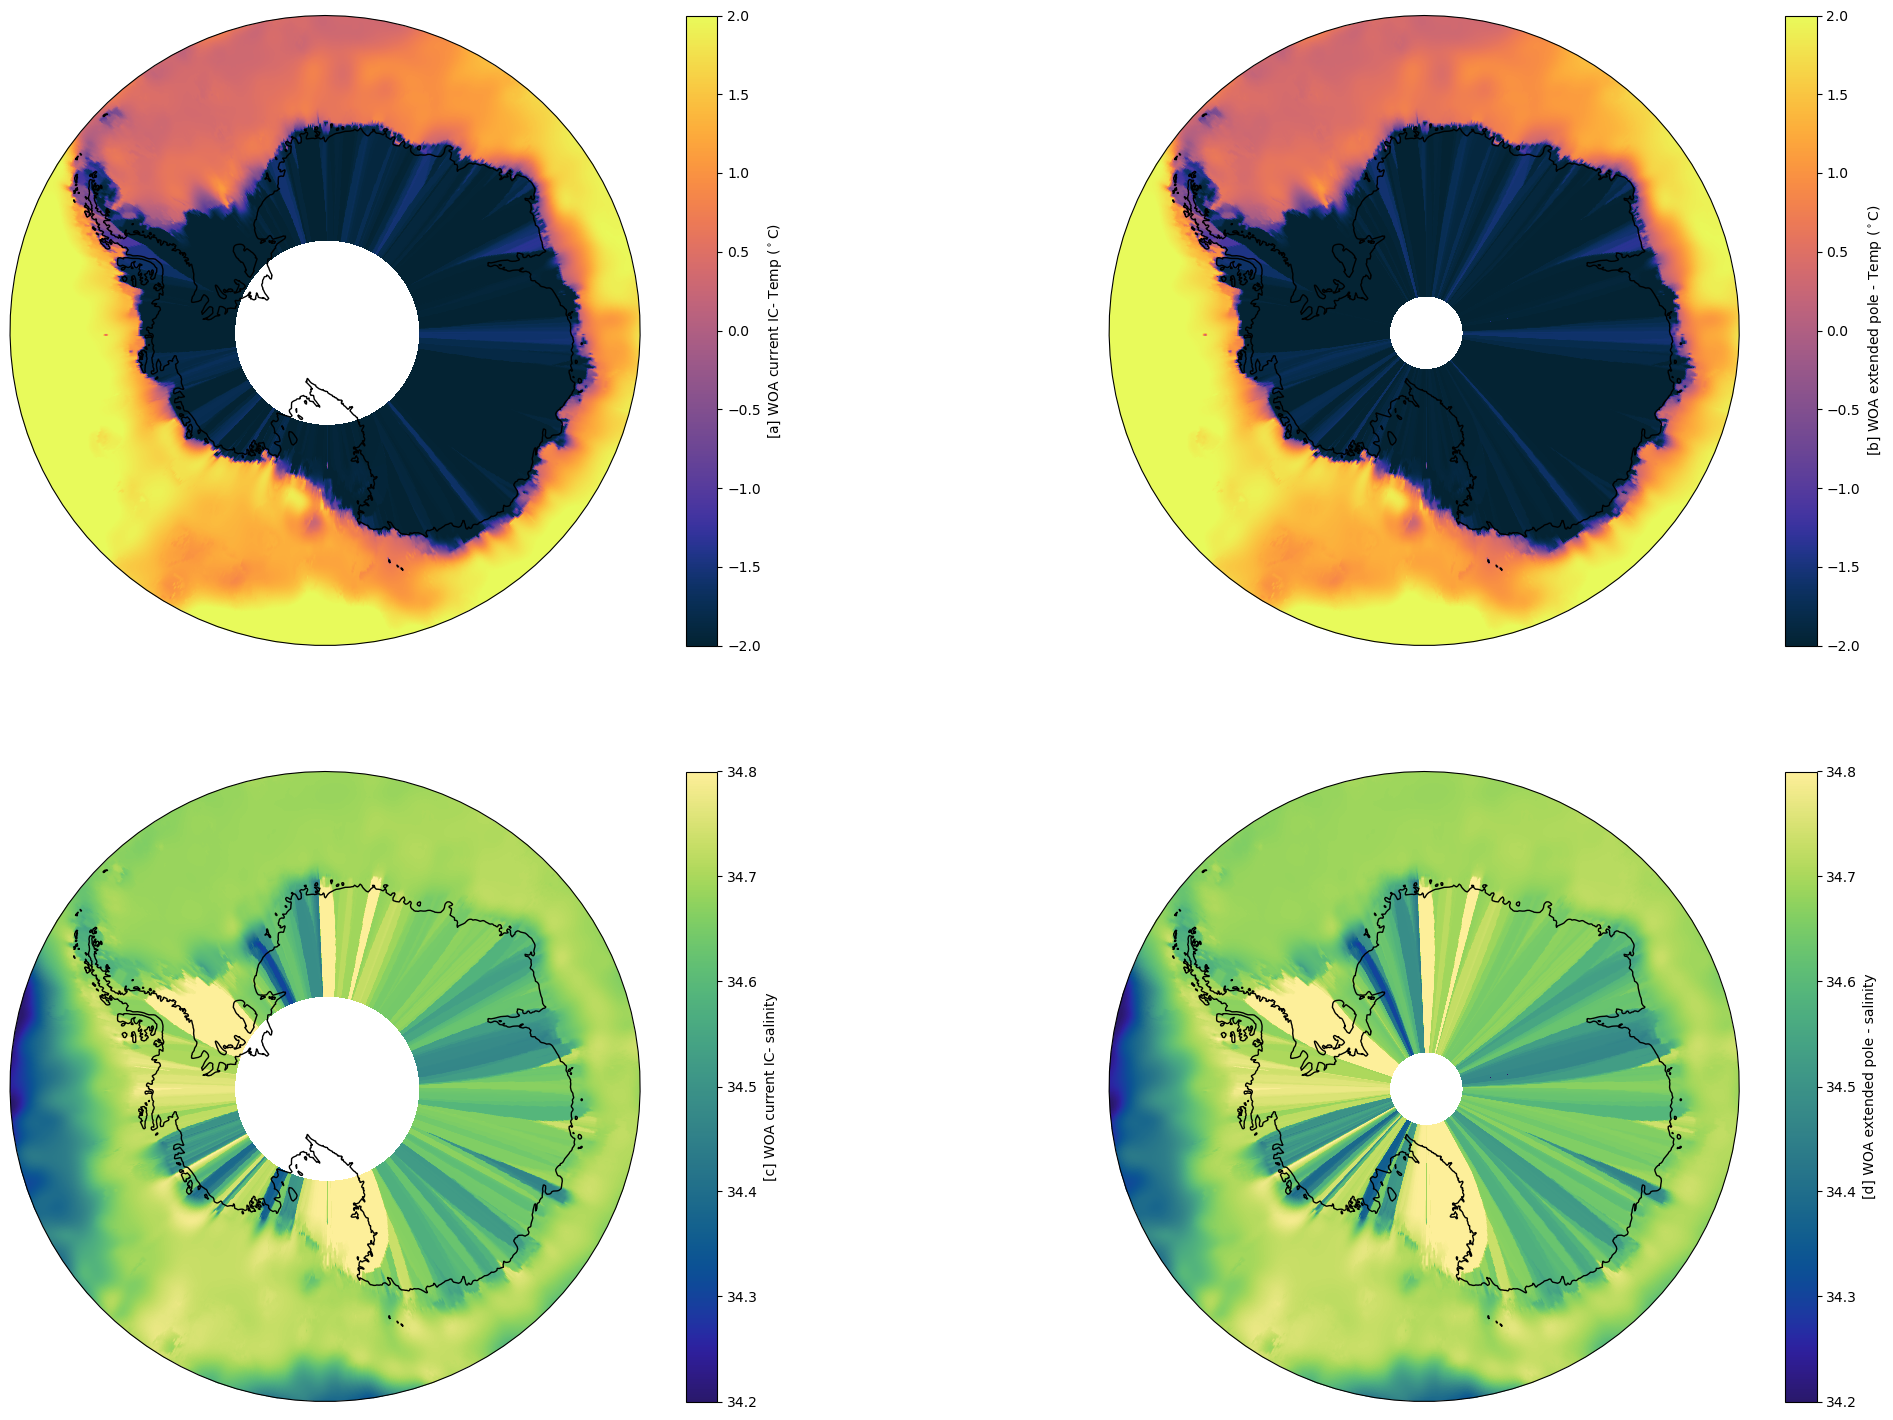

In [12]:
# import some useful packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.path as mpath



temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = 2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.8#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 34.2#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] WOA current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(WOA_IC_for_8km.nxp,
               WOA_IC_for_8km.nyp,
               WOA_IC_for_8km.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] WOA extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.salt.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] WOA current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(WOA_IC_for_8km.nxp,
               WOA_IC_for_8km.nyp,
               WOA_IC_for_8km.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] WOA extended pole - salinity')




In [13]:
target_depth = 0

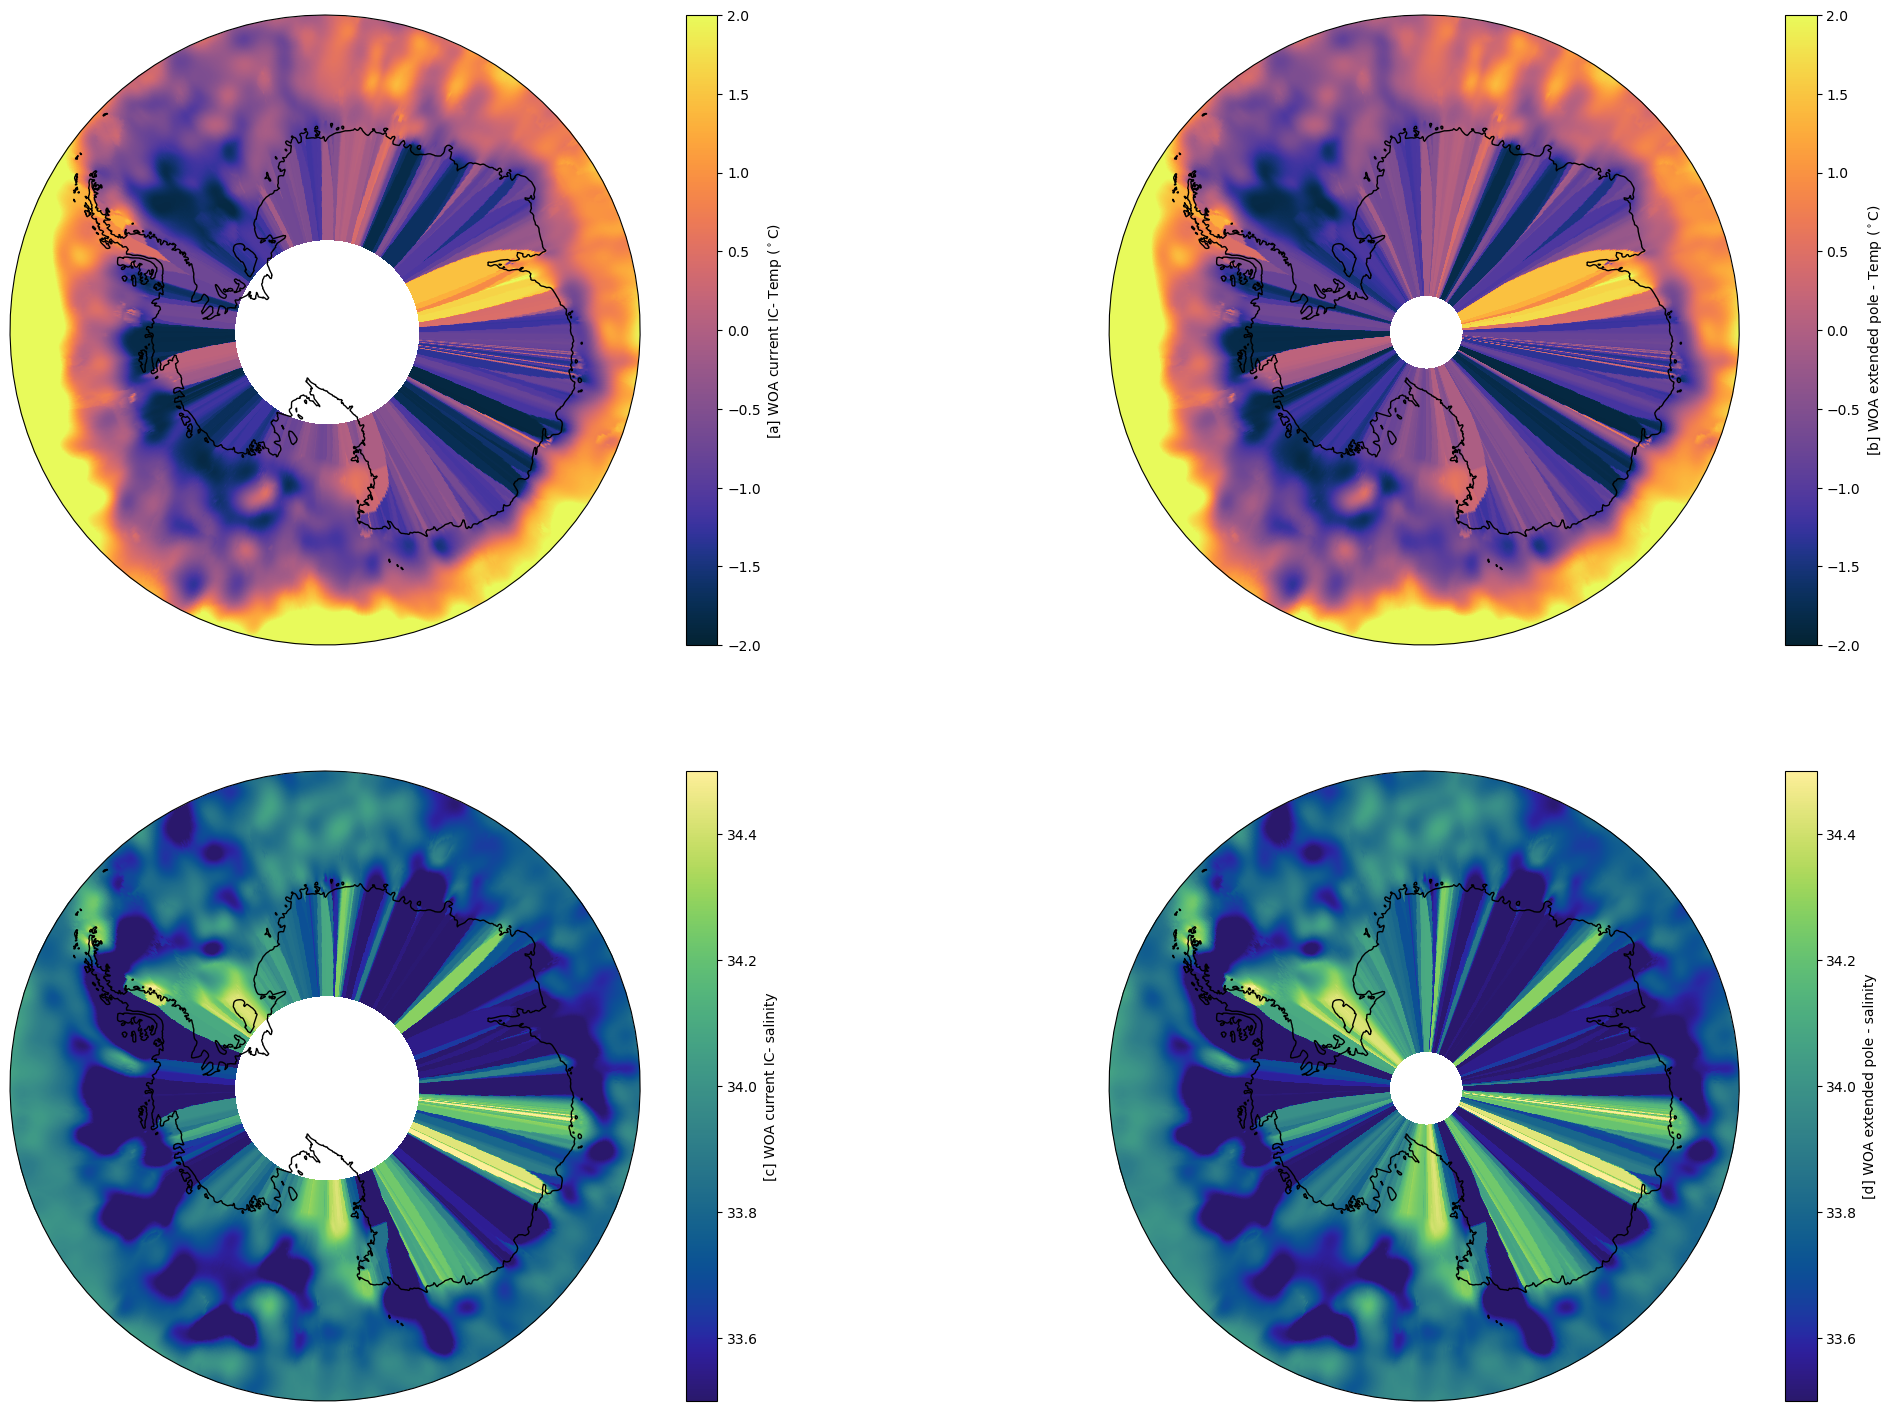

In [14]:
# import some useful packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.path as mpath



temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = 2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.5#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 33.5#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] WOA current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(WOA_IC_for_8km.nxp,
               WOA_IC_for_8km.nyp,
               WOA_IC_for_8km.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] WOA extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.salt.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] WOA current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(WOA_IC_for_8km.nxp,
               WOA_IC_for_8km.nyp,
               WOA_IC_for_8km.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] WOA extended pole - salinity')




_______________________________

## Longitude-smoothed version on land

Out of curiosity, I can try to just befille horzontally, or smooth the continent to see if the Bellingshausen leakage is fixed

In [84]:
ocean_mask_target_dir = '/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_mask.nc'
ocean_mask_target = xr.open_dataset(ocean_mask_target_dir).isel(ny=slice(0,1442)).\
mask.rename({'nx':'nxp','ny':'nyp'})
ocean_mask_target['nxp'] = WOA_IC_for_8km.nxp.values
ocean_mask_target['nyp'] = WOA_IC_for_8km.nyp.values
ocean_mask_target_land = ocean_mask_target.where(ocean_mask_target==0)+1
ocean_mask_target_ocean = ocean_mask_target.where(ocean_mask_target==1)

In [206]:
#creating fuzzy weights in boundary for stiching
weights_for_nonsmoothed = ocean_mask_target_land.copy()
offset=50 #normal is 50
minweight=0.00001
weights_for_nonsmoothed[0:(1134-offset),:] = (weights_for_nonsmoothed[offset:1134,:]-minweight).values
weights_for_nonsmoothed = (weights_for_nonsmoothed).fillna(0)
weights_for_nonsmoothed = ocean_mask_target_land - weights_for_nonsmoothed
weights_for_nonsmoothed[1115:,:] =weights_for_nonsmoothed[1115:,:]*0 +1
weights_for_nonsmoothed = weights_for_nonsmoothed.where(weights_for_nonsmoothed<0.99)
weights_for_nonsmoothed = weights_for_nonsmoothed.fillna(0) + ocean_mask_target_ocean.fillna(0)
weights_for_nonsmoothed = weights_for_nonsmoothed.where(weights_for_nonsmoothed>0)
weights_for_nonsmoothed[1115:,:] =weights_for_nonsmoothed[1115:,:].fillna(1)
weights_for_nonsmoothed = weights_for_nonsmoothed.interpolate_na(dim='nyp', method="linear", fill_value="extrapolate")
weights_for_smoothed = 1 - weights_for_nonsmoothed

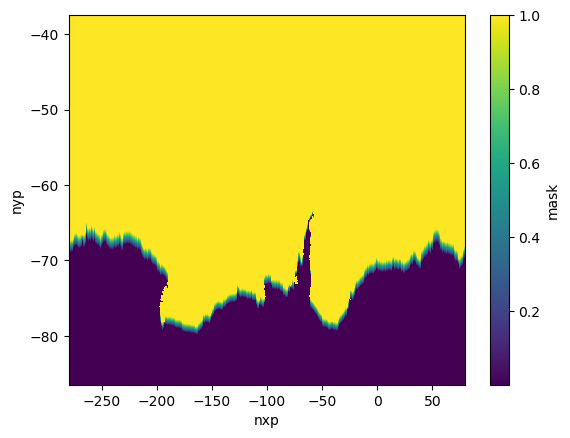

In [207]:
weights_for_nonsmoothed.plot()

Regions above with mask = 1 will fully have ocean data from WOA. Regions with mask <1 have the smoothed bottom filled data. Fuzzy boundary with the range between 0 and 1 representing the level of smoothing applied ( 0 is the highest smoothing).

Smoothing is purely zonal, and window for smoothing is set up in the next cells




In [ ]:
WOA_IC_for_8km_2 = WOA_IC_for_8km.copy()
#Line below can be omitted or maintained by choice. it just assure we are only smoothing the land moints, to avoint offshore points to leak zonally into the shelf
WOA_IC_for_8km_2 = (WOA_IC_for_8km_2* (ocean_mask_target.where(ocean_mask_target==0)+1)).ffill('nyp')

WOA_IC_for_8km_2  =xr.concat((WOA_IC_for_8km_2.isel(nxp=slice(-500,-1)),WOA_IC_for_8km_2 ,WOA_IC_for_8km_2.isel(nxp=slice(0,500))),dim='nxp')
newlon = WOA_IC_for_8km_2.nxp.values
newlon[0:499]= np.sort(((WOA_IC_for_8km_2.nxp[1:500]* 0 + WOA_IC_for_8km_2.nxp.min()) - ( WOA_IC_for_8km_2.nxp[1:3].diff('nxp').values*(WOA_IC_for_8km_2.nxp[1:500]* 0+1) ).cumsum()[::-1]))
newlon[-500:]= np.sort(((WOA_IC_for_8km_2.nxp[-500:]* 0 + WOA_IC_for_8km_2.nxp.max()) + ( WOA_IC_for_8km_2.nxp[1:3].diff('nxp').values*(WOA_IC_for_8km_2.nxp[-500:]* 0+1) ).cumsum()[::-1]))
WOA_IC_for_8km_2['nxp'] = newlon

On the line below you can choose to do a zonal + meridional, or solely zonal smoothing

In [276]:
#WOA smoothed full domain. mask will be applied later
nxwindow = 600 #600 (approx 0.138*nxp)seems to be quite good the 8km model. This will have to be adjusted for a higher res model
nywindow = 10
# WOA_IC_for_8km_smoothed_land = (WOA_IC_for_8km).rolling(nxp=nxwindow,min_periods=1).mean()\
# .rolling(nyp=nywindow,min_periods=1).mean()* ocean_mask_target_land #zonal and meridional smoothing
WOA_IC_for_8km_smoothed_land = (WOA_IC_for_8km_2).rolling(nxp=nxwindow,min_periods=1,center=True).mean() * ocean_mask_target_land #zonal smoothing alone
WOA_IC_for_8km_nonsmoothed_land = (WOA_IC_for_8km_2)* ocean_mask_target_land

WOA_IC_for_8km_smoothed_land = (WOA_IC_for_8km_smoothed_land*weights_for_smoothed) + (WOA_IC_for_8km_nonsmoothed_land*weights_for_nonsmoothed)
# #below with ice shelves smoothed
WOA_IC_for_8km_smoothed = WOA_IC_for_8km_smoothed_land.fillna(0) + (WOA_IC_for_8km *ocean_mask_target_ocean).fillna(0)



In [287]:
target_depth = 0

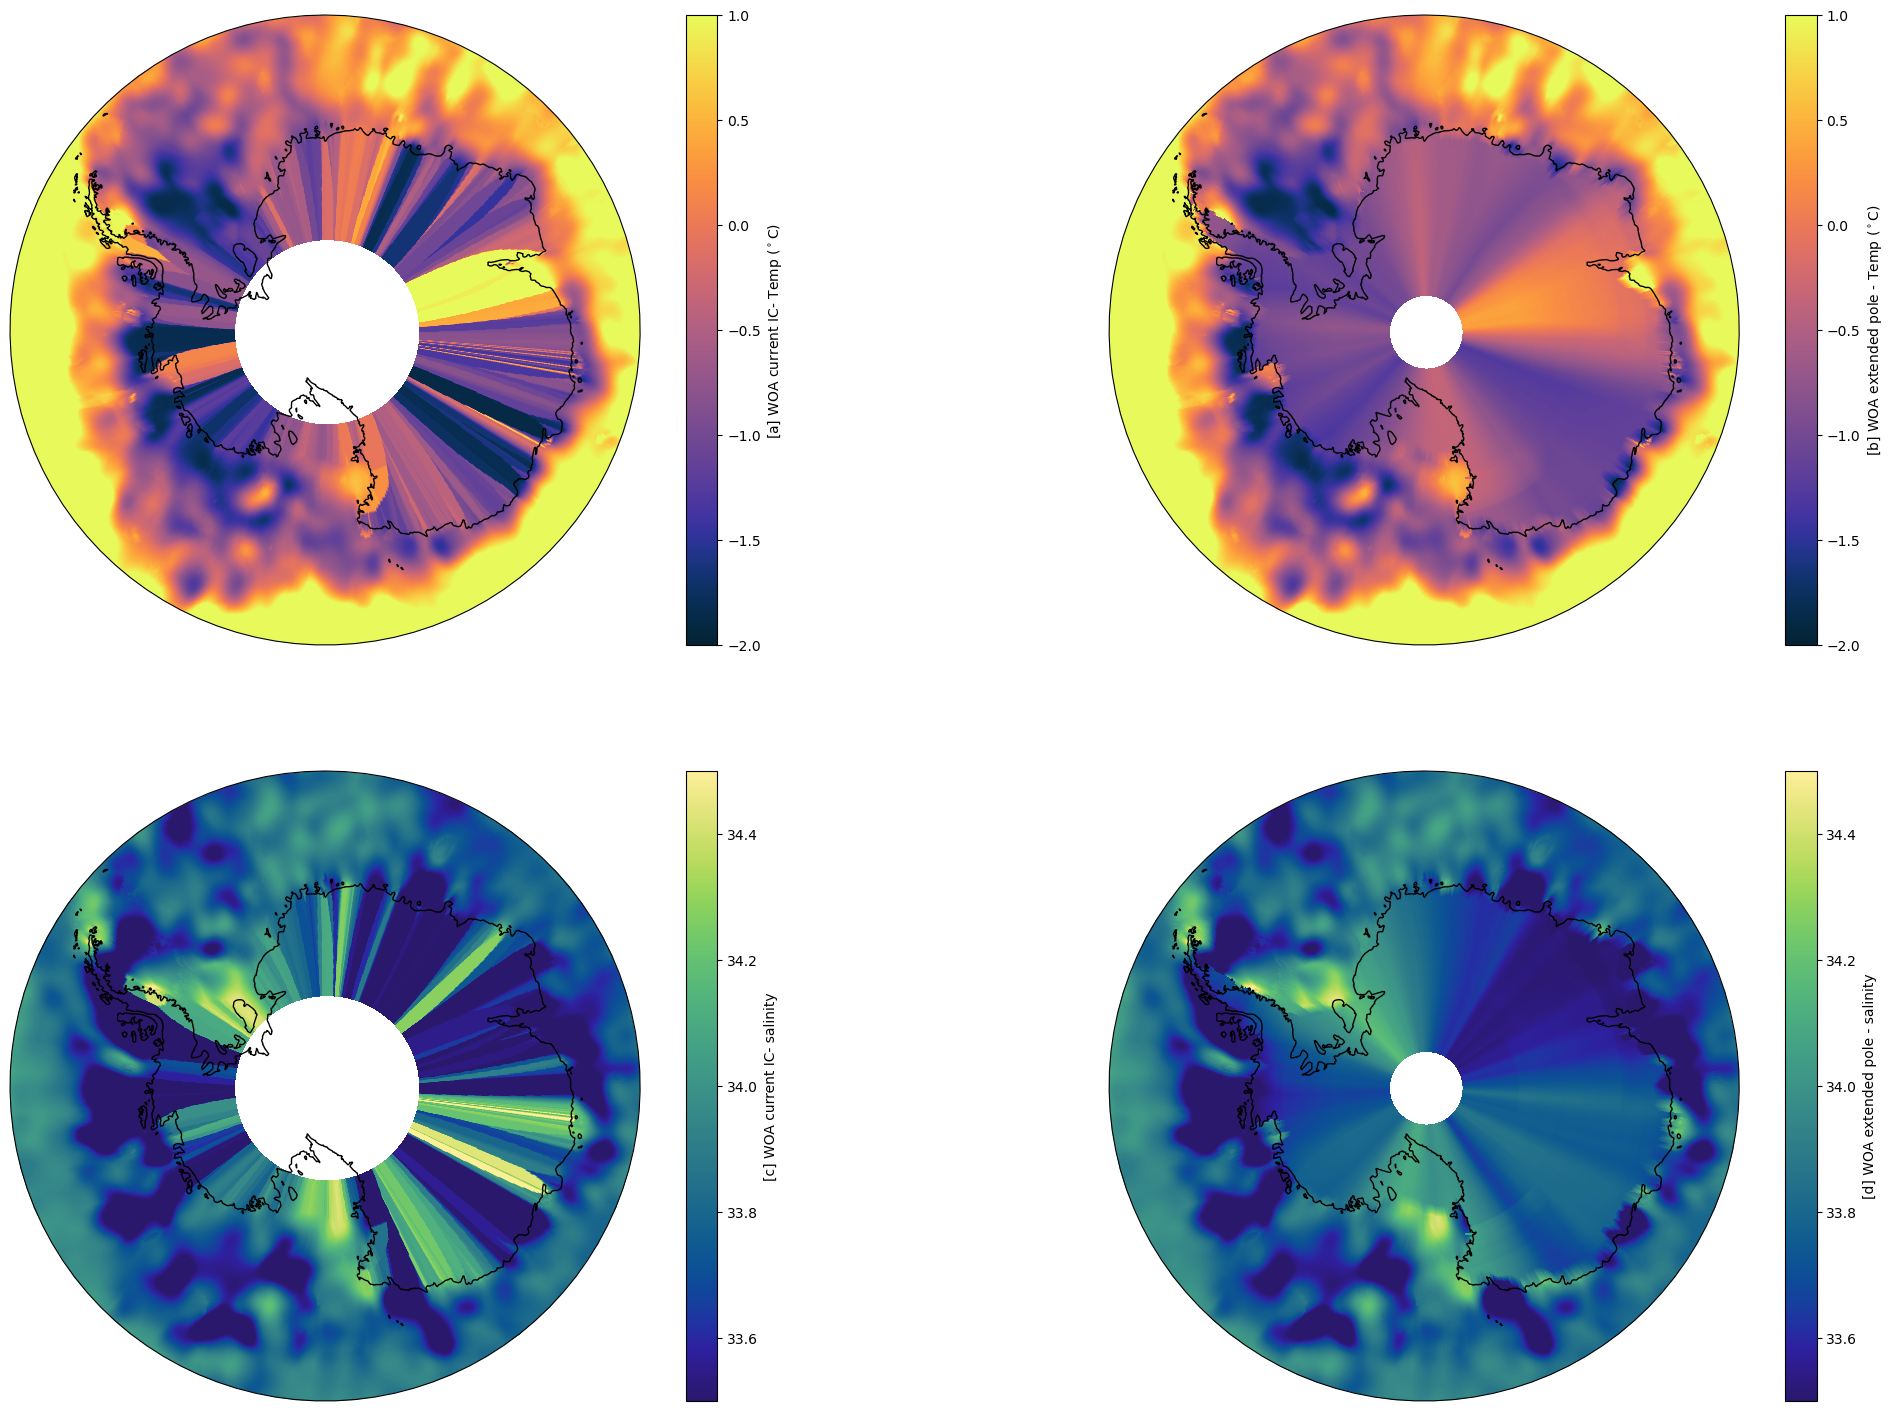

In [288]:
# import some useful packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.path as mpath



temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = 1#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.5#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 33.5#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] WOA current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(WOA_IC_for_8km_smoothed.nxp,
               WOA_IC_for_8km_smoothed.nyp,
               WOA_IC_for_8km_smoothed.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] WOA extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.salt.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] WOA current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(WOA_IC_for_8km_smoothed.nxp,
               WOA_IC_for_8km_smoothed.nyp,
               WOA_IC_for_8km_smoothed.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] WOA extended pole - salinity')



In [289]:
target_depth = 500

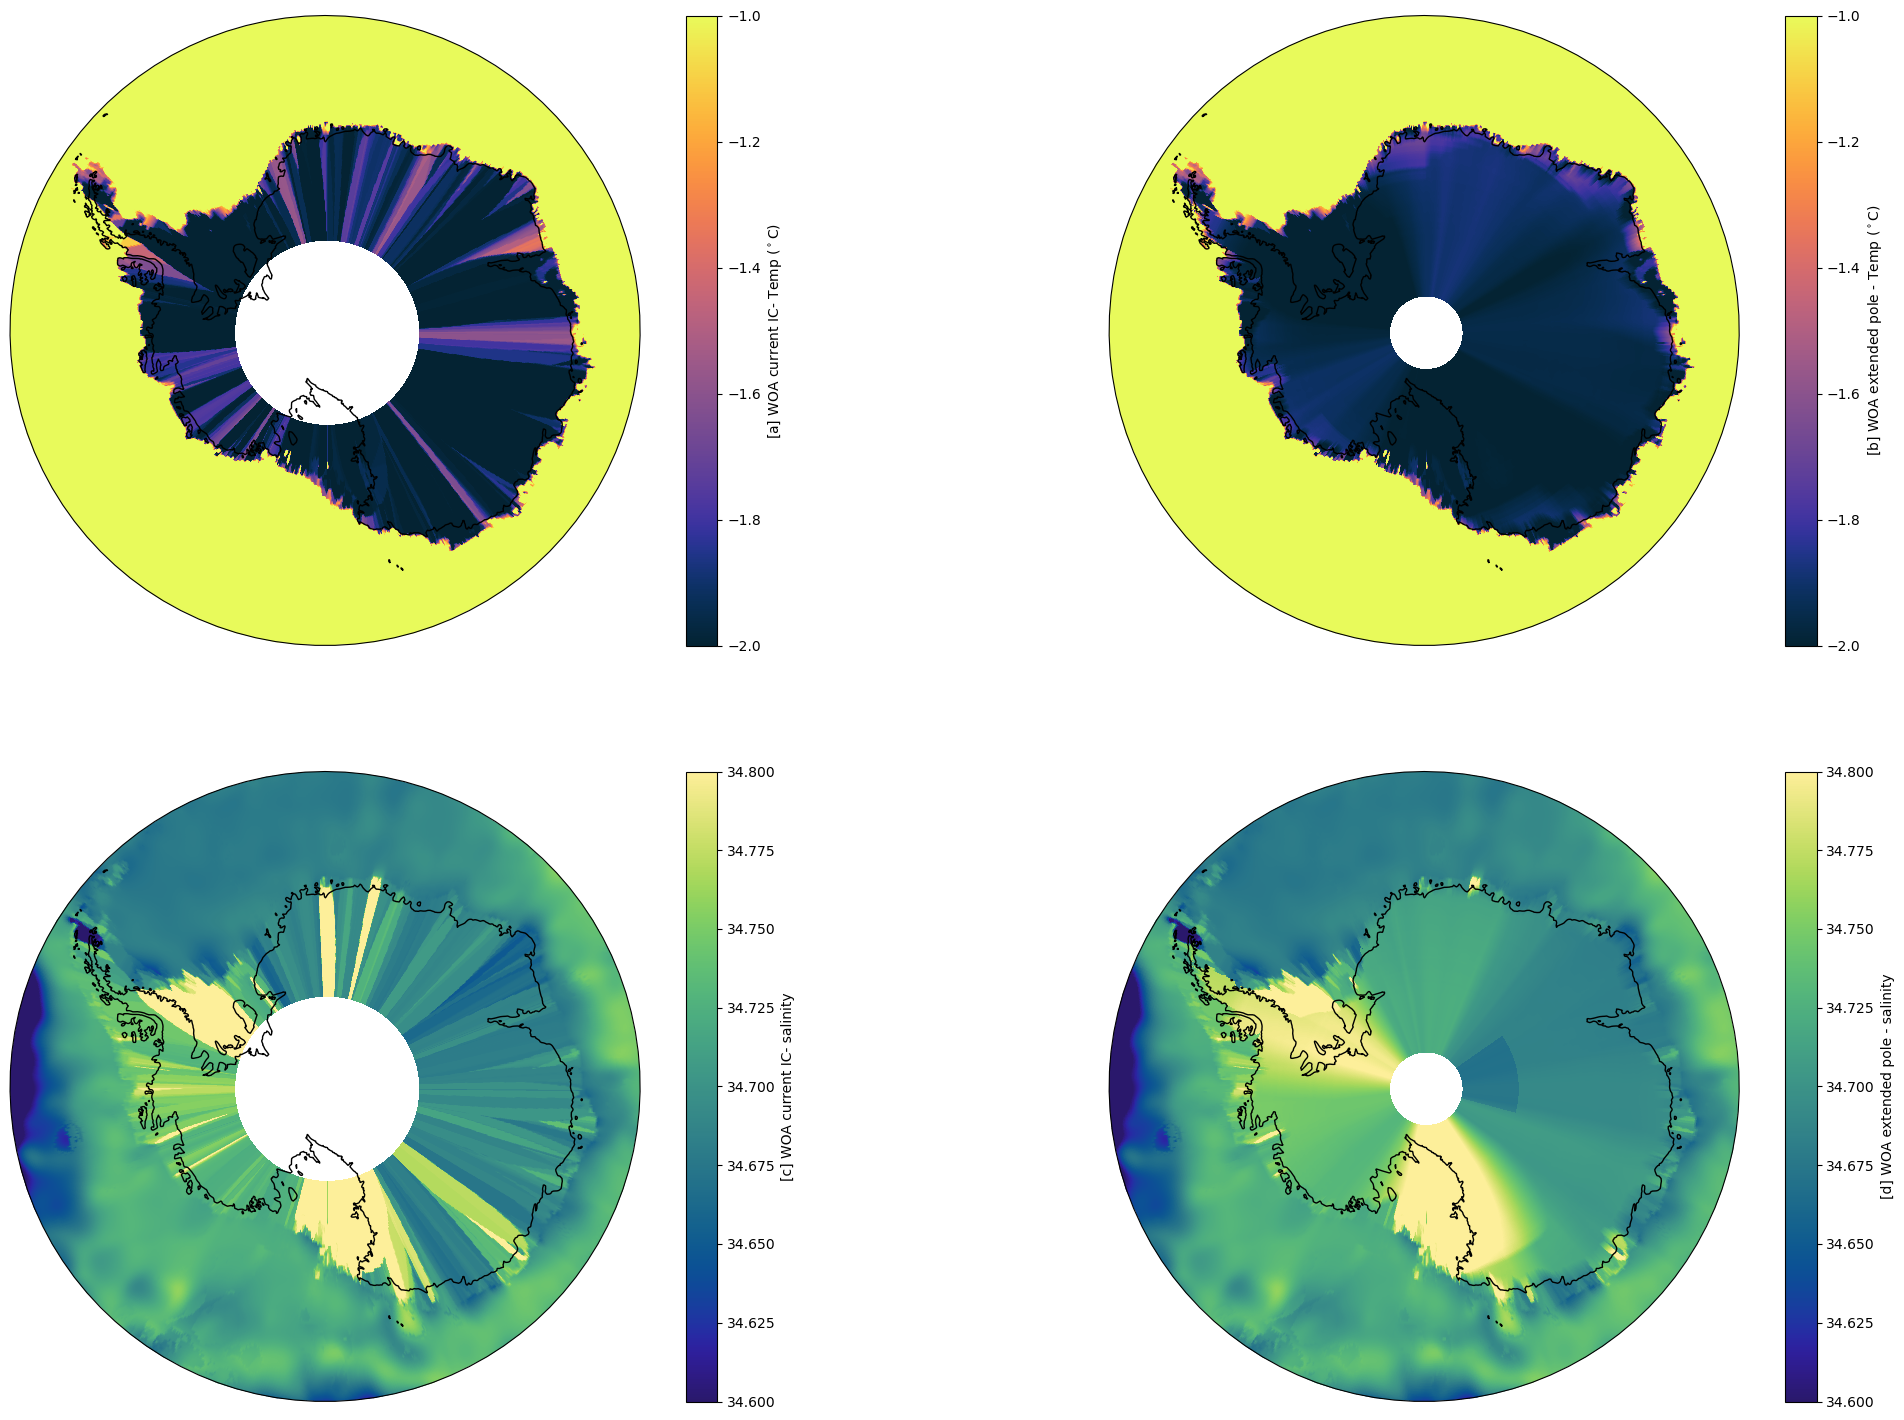

In [295]:
temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = -1#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.8#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 34.6#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] WOA current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(WOA_IC_for_8km_smoothed.nxp,
               WOA_IC_for_8km_smoothed.nyp,
               WOA_IC_for_8km_smoothed.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] WOA extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.salt.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] WOA current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(WOA_IC_for_8km_smoothed.nxp,
               WOA_IC_for_8km_smoothed.nyp,
               WOA_IC_for_8km_smoothed.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] WOA extended pole - salinity')




In [296]:
target_depth = 1000

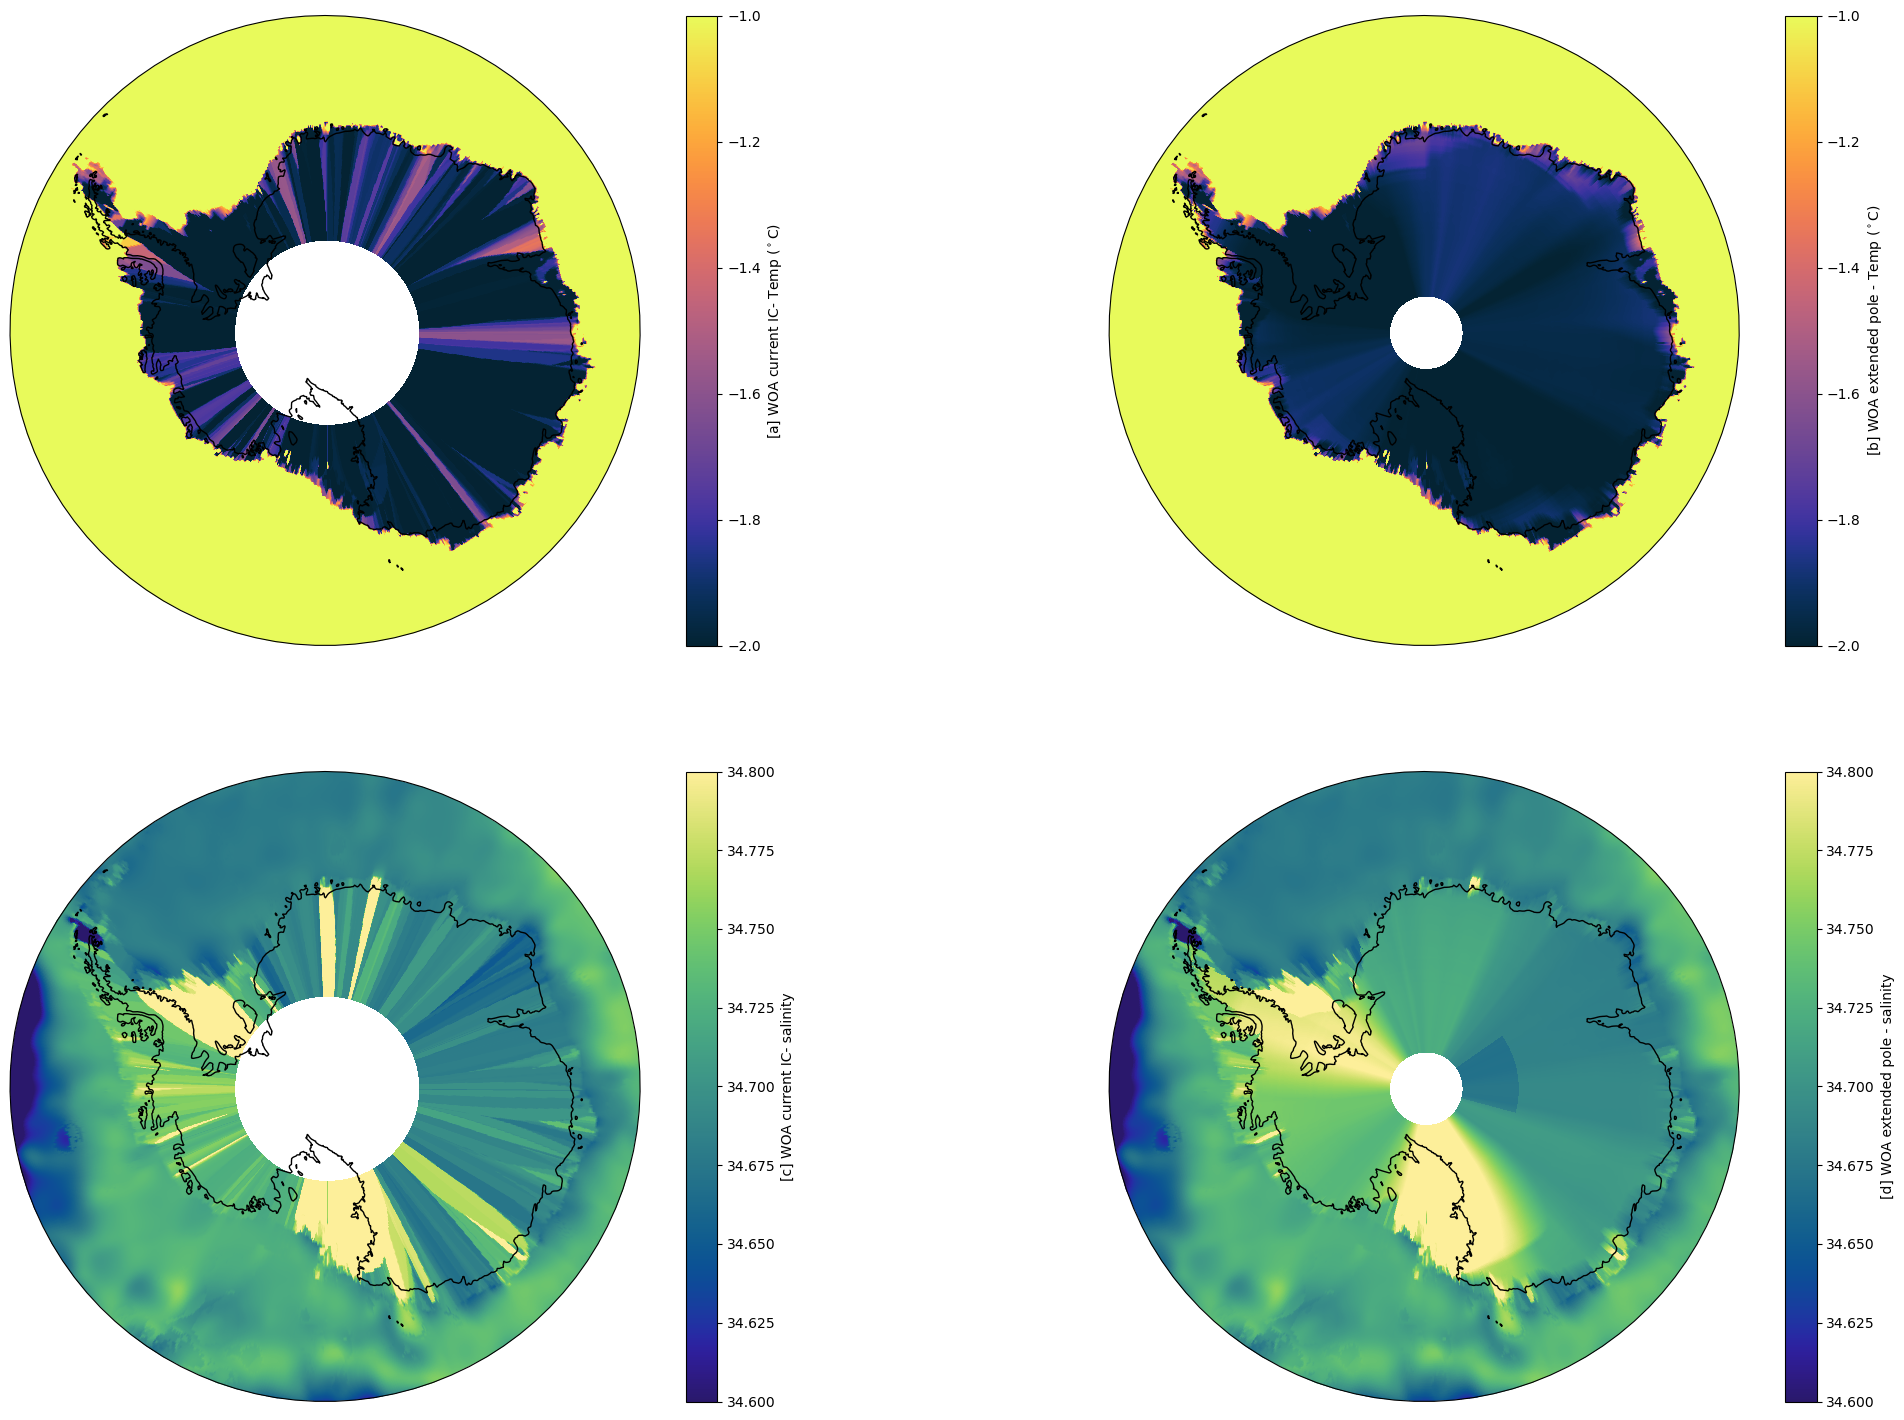

In [297]:
temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = -1#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.8#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 34.6#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] WOA current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(WOA_IC_for_8km_smoothed.nxp,
               WOA_IC_for_8km_smoothed.nyp,
               WOA_IC_for_8km_smoothed.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] WOA extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.salt.sel(ZT=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] WOA current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(WOA_IC_for_8km_smoothed.nxp,
               WOA_IC_for_8km_smoothed.nyp,
               WOA_IC_for_8km_smoothed.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] WOA extended pole - salinity')



In [298]:

WOA_IC_for_8km_smoothed.to_netcdf("/g/data/ik11/users/wf4500/mom6-panAn-iceshelf-tools/initial-conditions/WOA_IC_bfilled_smoothedland.nc", encoding={"temp": enc_TS, "salt": enc_TS})


It doesnt seem that bad

## Transects analysis

We need to check if there is some warm waters leakage to the shelf in this approach. Let's check that using some transects.

In [299]:
lat_slice_forplot=slice(-87,-55)
ocean_topog_target_dir = '/g/data/x77/ahg157/inputs/mom6/global-8km/topog.nc'
ocean_topog_target = xr.open_dataset(ocean_topog_target_dir).isel(ny=slice(0,1442))
ocean_topog_target['ny'] = WOA_IC_for_8km_smoothed.nyp.values
ocean_topog_target['nx'] = WOA_IC_for_8km_smoothed.nxp.values
ocean_topog_target = ocean_topog_target.sel(ny=lat_slice_forplot).depth.fillna(0)

dashed blue line marks the northern start of the extrapolation

(-69.0, -65.0)

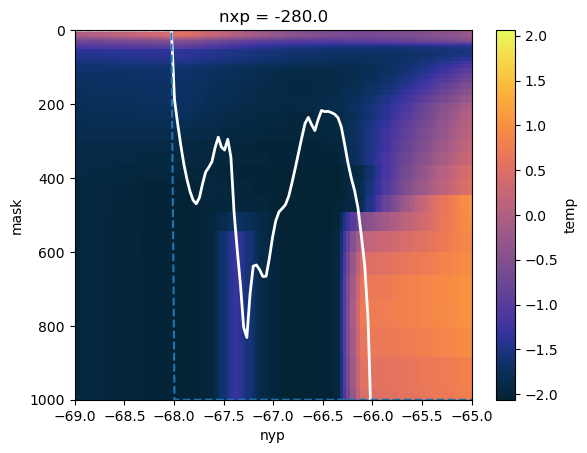

In [300]:
transect_ind = 0

WOA_IC_for_8km_smoothed.temp.isel(nxp=transect_ind).sel(nyp=lat_slice_forplot).plot(y='depth',cmap=cmo.thermal)
ocean_topog_target.isel(nx=transect_ind).plot(x='ny',color='white',linewidth=2)
(1000*ocean_mask_target.isel(nxp=transect_ind)).plot(x='nyp',linestyle='--')
plt.ylim(1000,0)
plt.xlim(-69,-65)

Transects with **smoothed data**

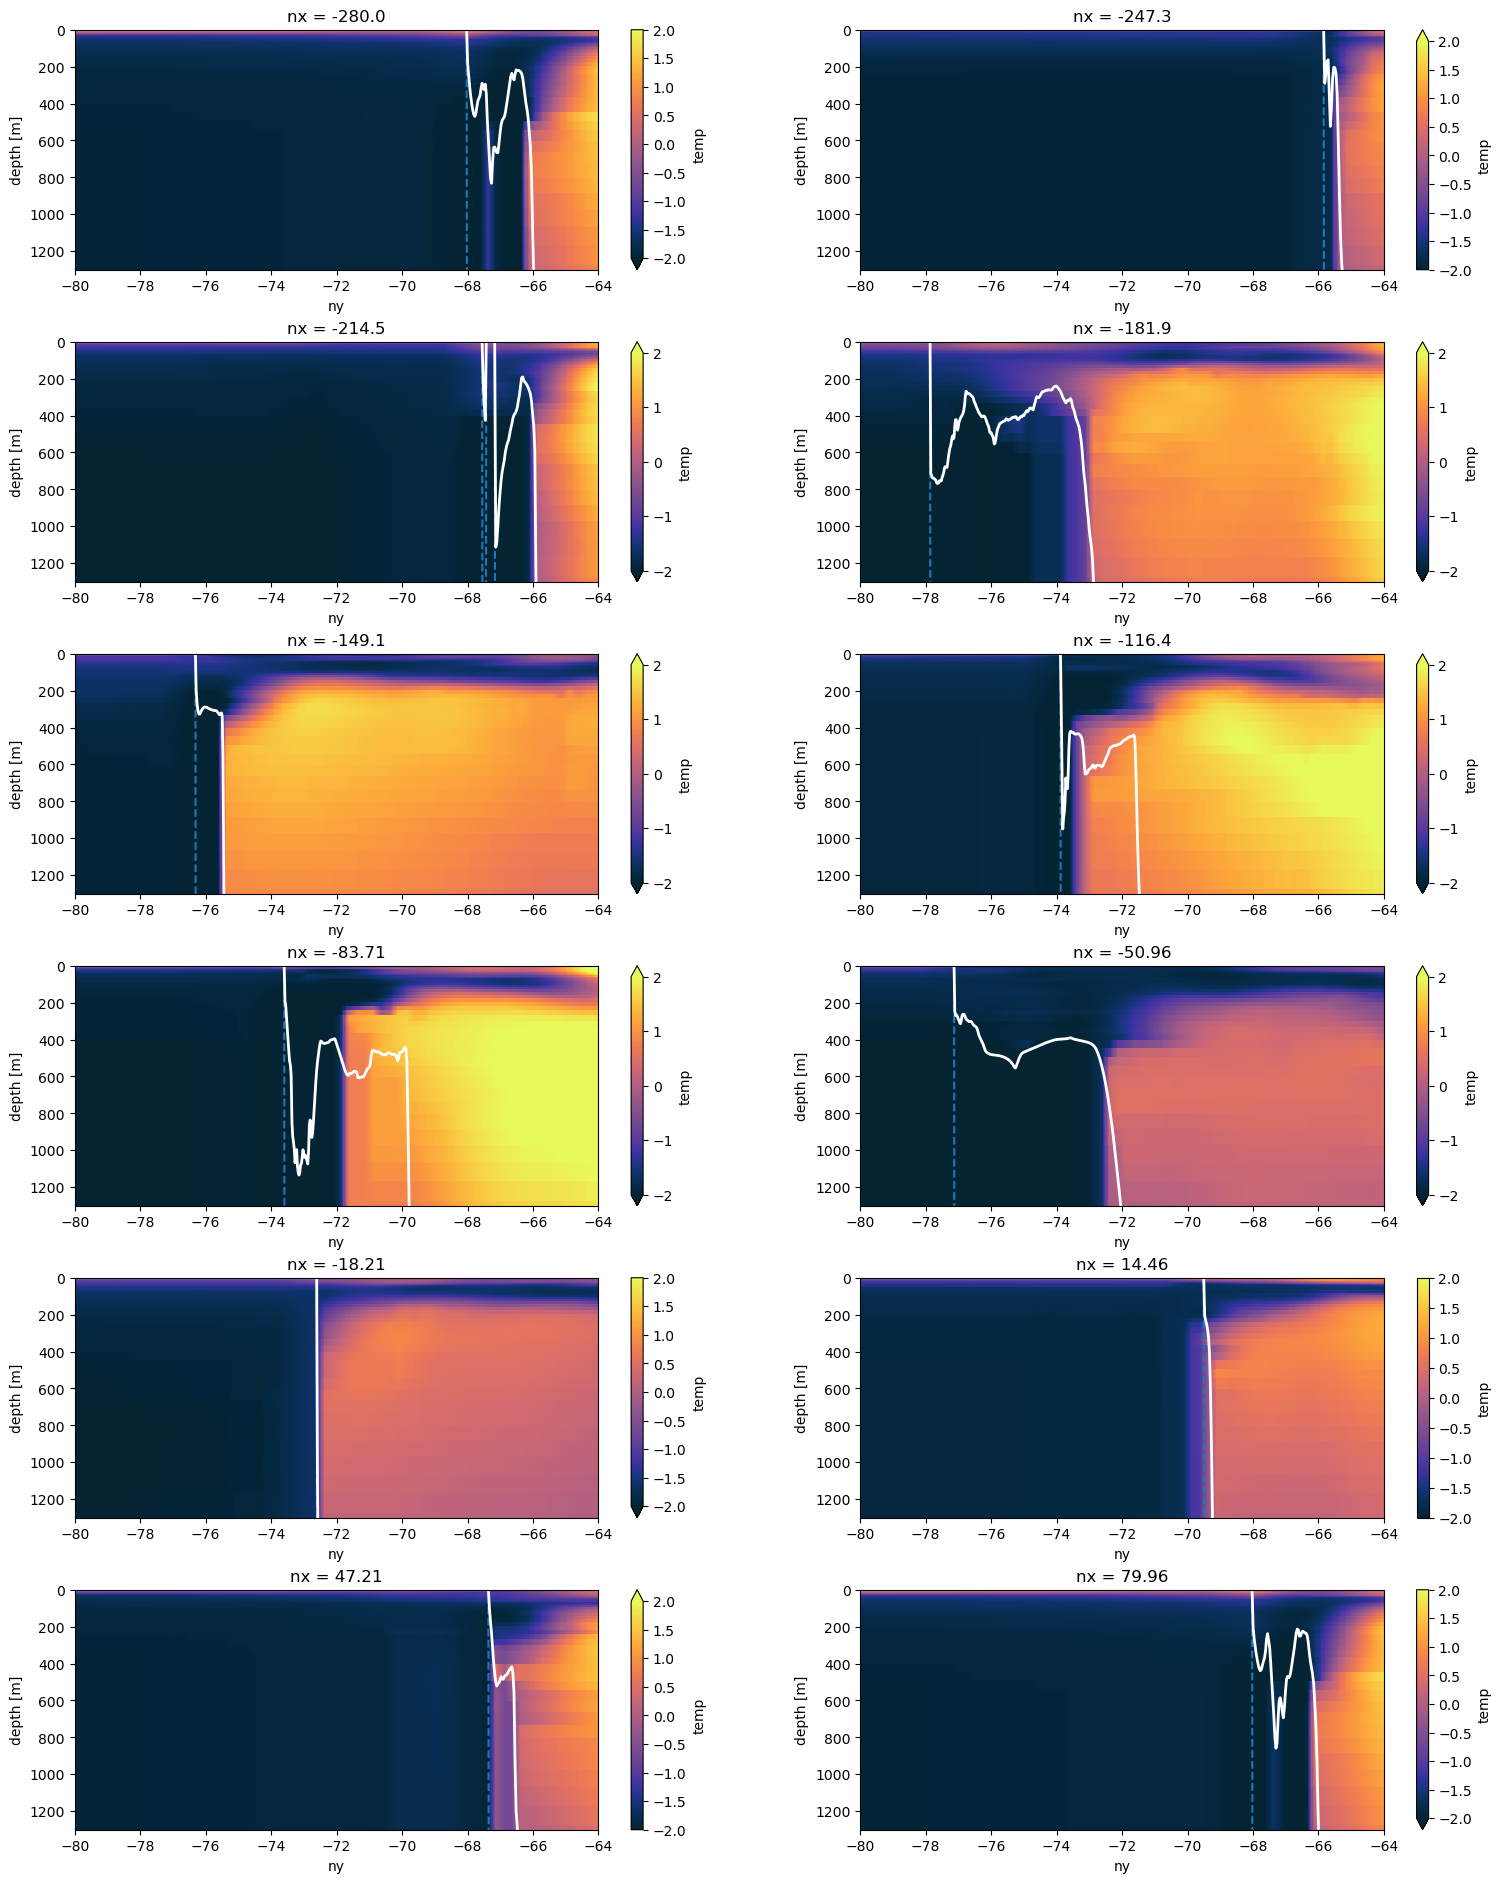

In [303]:
plt.figure(figsize=(16,20))
plt.subplots_adjust(left=0.05, right=0.95, 
                    top=0.95, bottom=0.05, 
                    wspace=0.2, hspace=0.3)

loopsize = 12
for k in range(loopsize):
    plt.subplot(6,2,k+1)
    transects_choice = np.linspace(0,4320-1,loopsize)
    transect_ind = int(transects_choice[k])
    WOA_IC_for_8km_smoothed.temp.isel(nxp=transect_ind).sel(nyp=lat_slice_forplot).plot(y='depth',cmap=cmo.thermal,vmin=-2,vmax=2)
    (5000*ocean_mask_target.isel(nxp=transect_ind)).plot(x='nyp',linestyle='--')
    ocean_topog_target.isel(nx=transect_ind).plot(x='ny',color='white',linewidth=2)
    plt.ylim(1300,0)
    plt.xlim(-80,-64)

transects with **non-smoothed data**

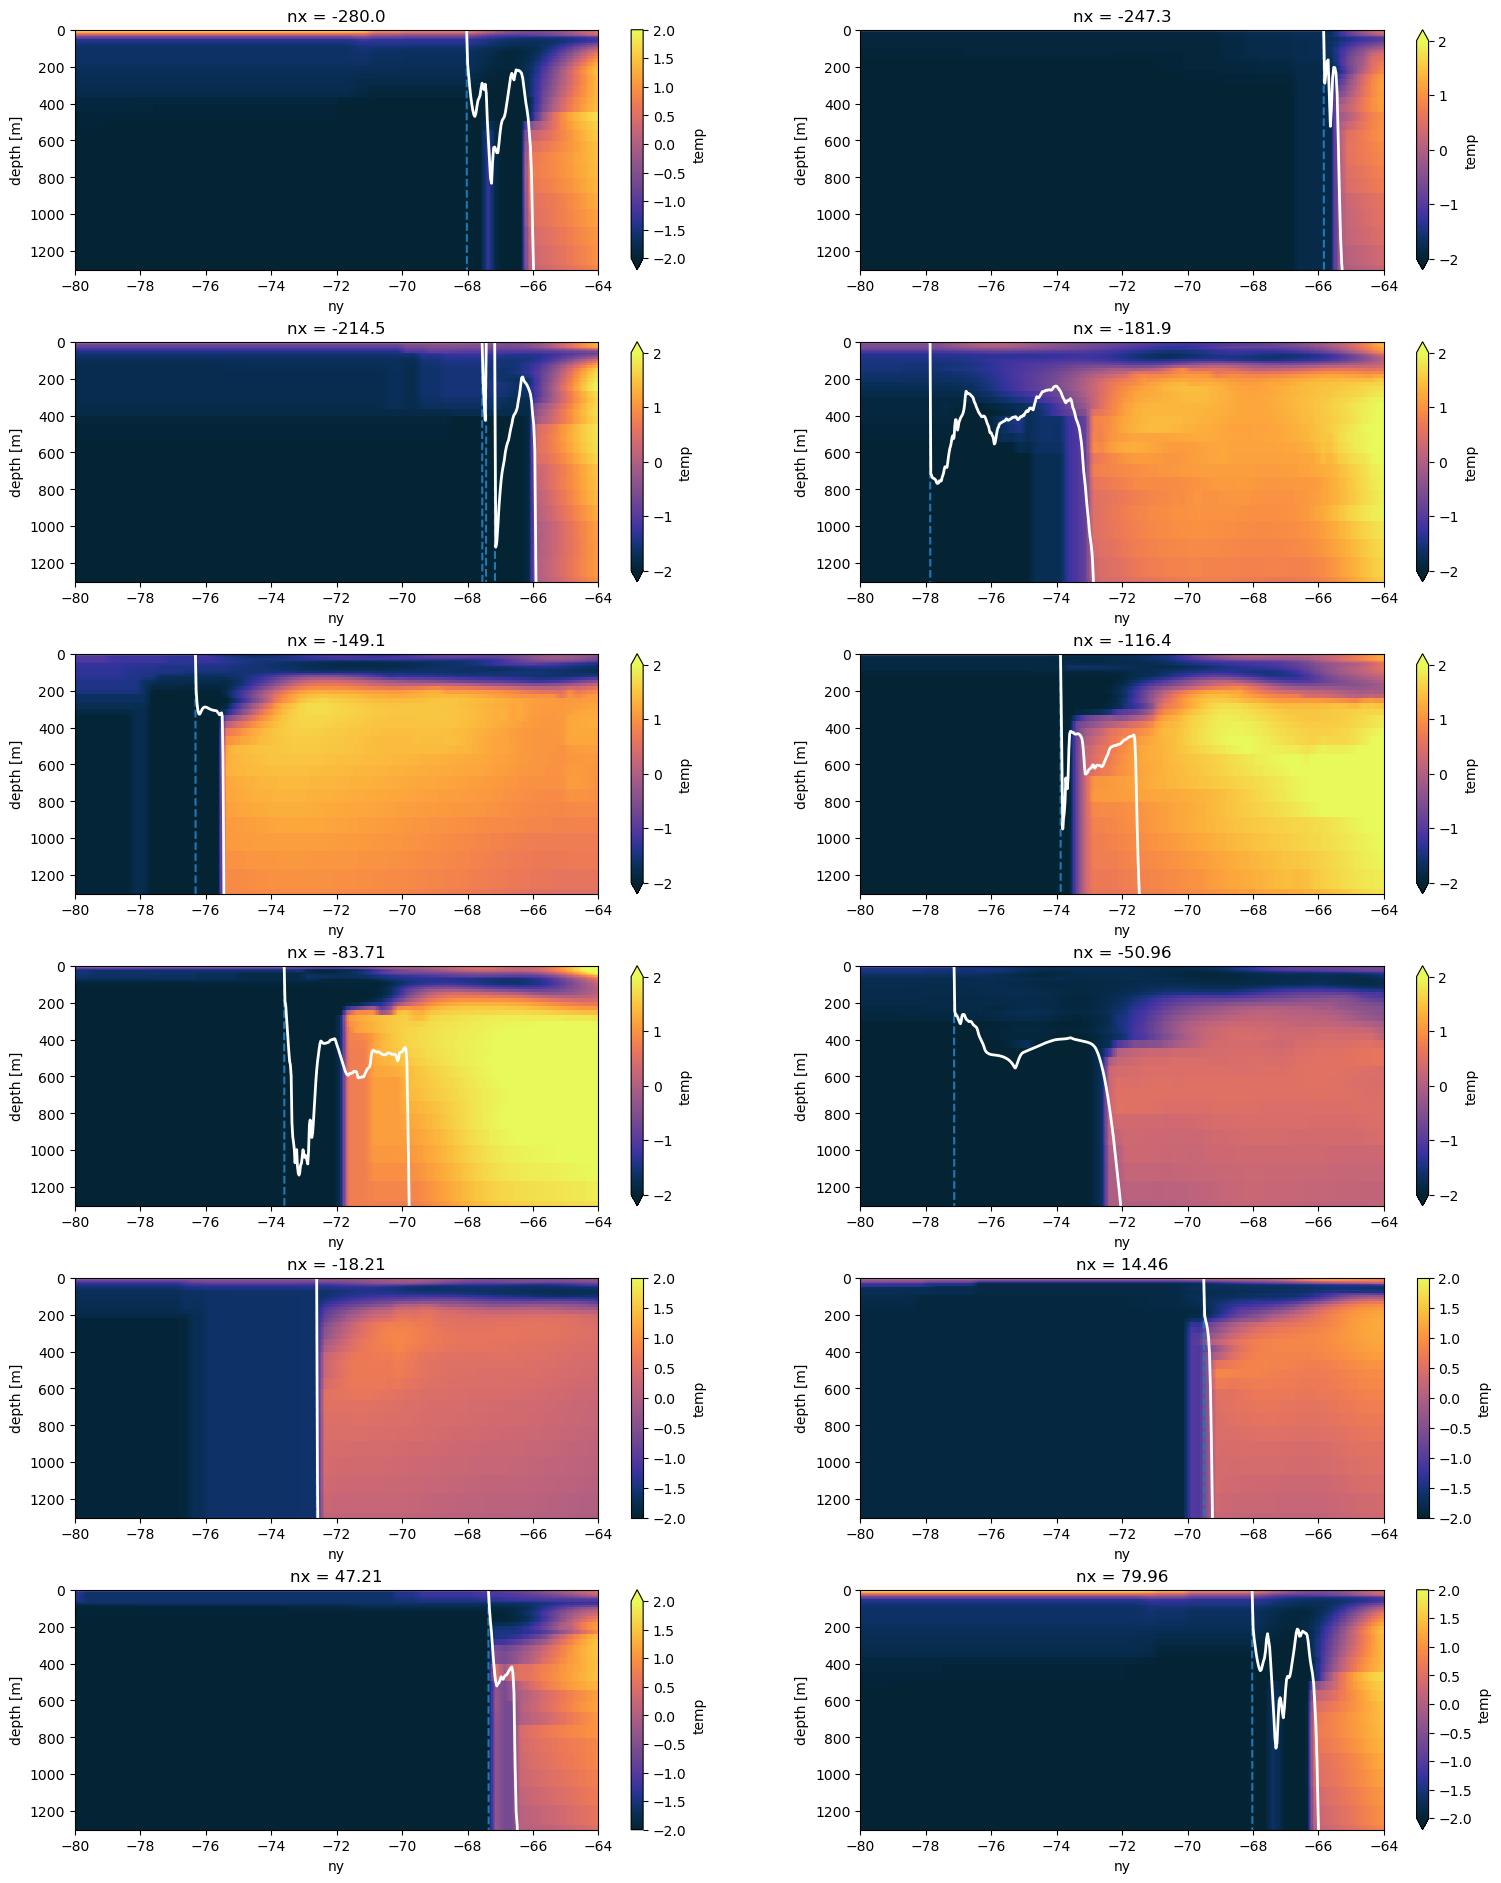

In [304]:
plt.figure(figsize=(16,20))
plt.subplots_adjust(left=0.05, right=0.95, 
                    top=0.95, bottom=0.05, 
                    wspace=0.2, hspace=0.3)

loopsize = 12
for k in range(loopsize):
    plt.subplot(6,2,k+1)
    transects_choice = np.linspace(0,4320-1,loopsize)
    transect_ind = int(transects_choice[k])
    WOA_IC_for_8km.temp.isel(nxp=transect_ind).sel(nyp=lat_slice_forplot).plot(y='depth',cmap=cmo.thermal,vmin=-2,vmax=2)
    (5000*ocean_mask_target.isel(nxp=transect_ind)).plot(x='nyp',linestyle='--')
    ocean_topog_target.isel(nx=transect_ind).plot(x='ny',color='white',linewidth=2)
    plt.ylim(1300,0)
    plt.xlim(-80,-64)

_____________________________________